In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import numpy as np
from PIL import Image
import random

In [2]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
def train_validate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(num_epochs):
        
        model.train()
        running_train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(predicted)
                all_labels.append(labels)

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        all_predictions = torch.cat(all_predictions).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

   
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
    }

In [4]:
def plot_val_metrics(metrics):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    epochs = range(1, len(metrics['train_losses']) + 1)

    ax1.plot(epochs, metrics['val_losses'], color='red')
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, metrics['val_accs'], color='blue')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [5]:
num_epochs=20
used_classes = [0, 1, 3, 4, 5, 6]

In [6]:
label_map = {old: new for new, old in enumerate(sorted(used_classes))}

def remap_label(label):
    if isinstance(label, torch.Tensor):
        return label_map[label.item()]
    return label_map[label]

class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = label_map

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y = self.label_map[int(y)]
        return x, y


In [7]:
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = dict(label_map)
        self.valid_remapped = set(range(len(label_map)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y = int(y.item() if torch.is_tensor(y) else y)

        if y in self.label_map:
            y = self.label_map[y]
        elif y in self.valid_remapped:
            pass                                  
        else:
            raise KeyError(
                f"Label {y} not in label_map and not already remapped "
                f"(expected one of {sorted(self.label_map.keys())} or 0..{len(self.valid_remapped)-1})."
            )
        return x, torch.tensor(y, dtype=torch.long)


In [8]:
def target_to_long(y):
    if isinstance(y, np.ndarray):
        y = int(y[0])
    else:
        y = int(y)
    return torch.tensor(y, dtype=torch.long)

In [9]:
class BlurredDataset(Dataset):
    def __init__(self, dataset, blur=None):
        self.dataset = dataset
        self.blur = blur or transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0))
        if hasattr(dataset, "labels"):
            self.labels = dataset.labels 

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.blur: 
            image = self.blur(image)
        if torch.is_tensor(label):
            label = label.long()
        else:
            label = torch.tensor(int(label), dtype=torch.long)
        return image, label

blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0))

## original bloodMNIST dataset

In [10]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset_original = DataClass(split='train', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)
valset_original   = DataClass(split='val', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)
testset_original  = DataClass(split='test', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)

train_used_idx = [
    i for i, (_, lbl) in enumerate(trainset_original)
    if lbl.item() in used_classes
]

val_used_idx = [
    i for i, (_, lbl) in enumerate(valset_original)
    if lbl.item() in used_classes
]

test_used_idx = [
    i for i, (_, lbl) in enumerate(testset_original)
    if lbl.item() in used_classes
]

trainset_filtered = Subset(trainset_original, train_used_idx)
valset_filtered   = Subset(valset_original, val_used_idx)
testset_filtered  = Subset(testset_original, test_used_idx)


trainset = RemappedDataset(trainset_filtered, label_map)
valset   = RemappedDataset(valset_filtered,   label_map)
testset  = RemappedDataset(testset_filtered,  label_map)

train_dataloader = DataLoader(trainset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=False)

In [11]:
label_counts = {}
for _, targets in train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 852 images
Label 1: 2181 images
Label 2: 2026 images
Label 3: 849 images
Label 4: 993 images
Label 5: 2330 images


Epoch 1/20 | Train Loss: 1.3548 | Val Loss: 0.9511 | Val Acc: 59.53% | Val Precision: 0.6723 | Val Recall: 0.5199 | Val F1: 0.4970
Epoch 2/20 | Train Loss: 0.7921 | Val Loss: 0.6870 | Val Acc: 74.13% | Val Precision: 0.7130 | Val Recall: 0.7165 | Val F1: 0.6926
Epoch 3/20 | Train Loss: 0.6256 | Val Loss: 0.5335 | Val Acc: 78.06% | Val Precision: 0.7791 | Val Recall: 0.7062 | Val F1: 0.7106
Epoch 4/20 | Train Loss: 0.5168 | Val Loss: 0.5413 | Val Acc: 78.67% | Val Precision: 0.7780 | Val Recall: 0.7402 | Val F1: 0.7377
Epoch 5/20 | Train Loss: 0.4691 | Val Loss: 0.6603 | Val Acc: 72.39% | Val Precision: 0.7551 | Val Recall: 0.6943 | Val F1: 0.6665
Epoch 6/20 | Train Loss: 0.4416 | Val Loss: 0.4104 | Val Acc: 84.57% | Val Precision: 0.8192 | Val Recall: 0.8324 | Val F1: 0.8205
Epoch 7/20 | Train Loss: 0.4020 | Val Loss: 0.4157 | Val Acc: 82.83% | Val Precision: 0.8216 | Val Recall: 0.8105 | Val F1: 0.7960
Epoch 8/20 | Train Loss: 0.3915 | Val Loss: 0.3867 | Val Acc: 83.51% | Val Precisio

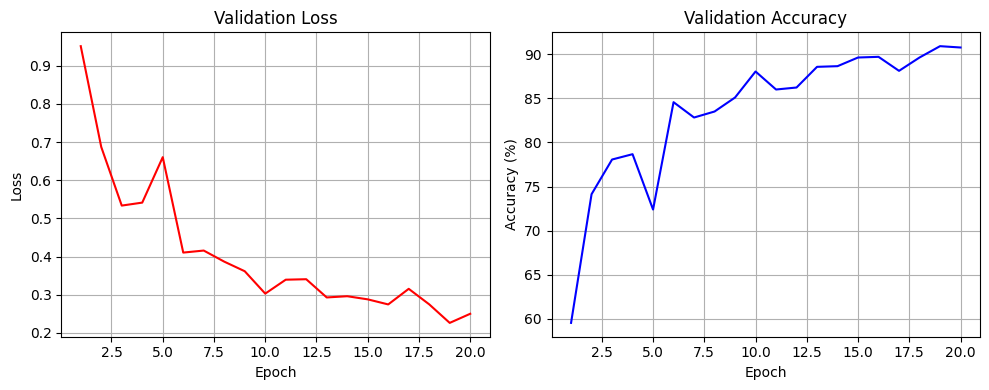

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(original_model.parameters(), lr=0.0015)

original_metrics = train_validate(
    model=original_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(original_metrics)

## generated images based on bloodMNIST

In [14]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2: 
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [15]:
generated_dataset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

total_size = len(generated_dataset)
generated_train_size = int(0.7 * total_size)
generated_val_size = int(0.1 * total_size)
generated_test_size = total_size - generated_train_size - generated_val_size

generated_trainset, generated_valset, generated_testset = random_split(
    generated_dataset,
    [generated_train_size, generated_val_size, generated_test_size],
    generator=torch.Generator().manual_seed(42)
)

generated_train_used_idx = [
    i for i, (_, lbl) in enumerate(generated_trainset)
    if lbl.item() in used_classes
]

generated_val_used_idx = [
    i for i, (_, lbl) in enumerate(generated_valset)
    if lbl.item() in used_classes
]

generated_test_used_idx = [
    i for i, (_, lbl) in enumerate(generated_testset)
    if lbl.item() in used_classes
]

generated_trainset_filtered = Subset(generated_trainset, generated_train_used_idx)
generated_valset_filtered   = Subset(generated_valset, generated_val_used_idx)
generated_testset_filtered  = Subset(generated_testset, generated_test_used_idx)

generated_trainset = RemappedDataset(generated_trainset_filtered, label_map)
generated_valset   = RemappedDataset(generated_valset_filtered,   label_map)
generated_testset  = RemappedDataset(generated_testset_filtered,  label_map)

generated_train_dataloader = DataLoader(generated_trainset, batch_size=128, shuffle=True)
generated_val_dataloader   = DataLoader(generated_valset, batch_size=128, shuffle=False)
generated_test_dataloader   = DataLoader(generated_testset, batch_size=128, shuffle=False)

In [16]:
label_counts = {}
for _, targets in generated_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 708 images
Label 1: 687 images
Label 2: 701 images
Label 3: 696 images
Label 4: 691 images
Label 5: 728 images


Epoch 1/20 | Train Loss: 1.6932 | Val Loss: 1.2949 | Val Acc: 65.51% | Val Precision: 0.7705 | Val Recall: 0.6632 | Val F1: 0.6485
Epoch 2/20 | Train Loss: 0.8403 | Val Loss: 0.6361 | Val Acc: 77.12% | Val Precision: 0.8033 | Val Recall: 0.7707 | Val F1: 0.7760
Epoch 3/20 | Train Loss: 0.5421 | Val Loss: 0.4541 | Val Acc: 85.10% | Val Precision: 0.8580 | Val Recall: 0.8543 | Val F1: 0.8516
Epoch 4/20 | Train Loss: 0.4586 | Val Loss: 0.3931 | Val Acc: 85.62% | Val Precision: 0.8666 | Val Recall: 0.8657 | Val F1: 0.8621
Epoch 5/20 | Train Loss: 0.3761 | Val Loss: 0.4020 | Val Acc: 85.44% | Val Precision: 0.8894 | Val Recall: 0.8592 | Val F1: 0.8618
Epoch 6/20 | Train Loss: 0.3421 | Val Loss: 0.3354 | Val Acc: 89.43% | Val Precision: 0.9063 | Val Recall: 0.9006 | Val F1: 0.8999
Epoch 7/20 | Train Loss: 0.2903 | Val Loss: 0.2640 | Val Acc: 92.03% | Val Precision: 0.9245 | Val Recall: 0.9248 | Val F1: 0.9232
Epoch 8/20 | Train Loss: 0.3177 | Val Loss: 0.2708 | Val Acc: 91.33% | Val Precisio

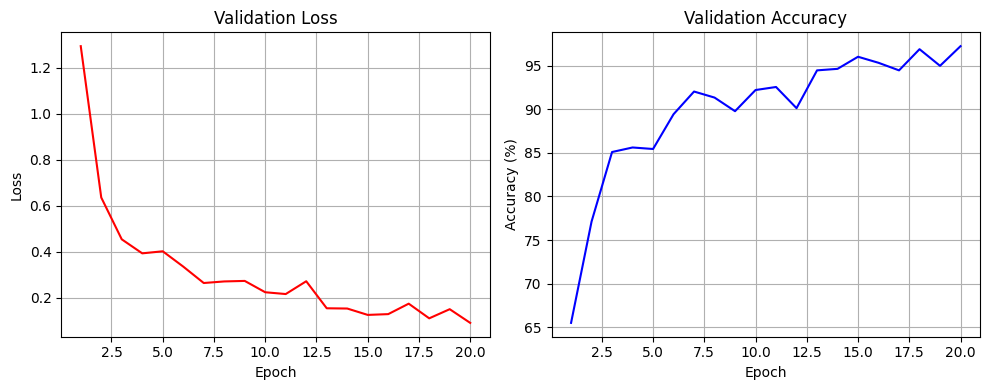

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(generated_model.parameters(), lr=0.0015)

generated_metrics = train_validate(
    model=generated_model,
    train_dataloader=generated_train_dataloader,
    val_dataloader=generated_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(generated_metrics)

## combined dataset

In [19]:
combined_trainset = ConcatDataset([trainset, generated_trainset])
combined_valset   = ConcatDataset([valset, generated_valset])
combined_testset  = ConcatDataset([testset, generated_testset])

combined_train_dataloader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
combined_val_dataloader   = DataLoader(combined_valset, batch_size=128, shuffle=False)
combined_test_dataloader  = DataLoader(combined_testset, batch_size=128, shuffle=False)


In [20]:
label_counts = {}
for _, targets in combined_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1560 images
Label 1: 2868 images
Label 2: 2727 images
Label 3: 1545 images
Label 4: 1684 images
Label 5: 3058 images


Epoch 1/20 | Train Loss: 1.2462 | Val Loss: 1.4586 | Val Acc: 41.18% | Val Precision: 0.5864 | Val Recall: 0.3671 | Val F1: 0.3459
Epoch 2/20 | Train Loss: 0.7201 | Val Loss: 3.3244 | Val Acc: 27.80% | Val Precision: 0.5381 | Val Recall: 0.2184 | Val F1: 0.1477
Epoch 3/20 | Train Loss: 0.6766 | Val Loss: 0.5572 | Val Acc: 77.41% | Val Precision: 0.8503 | Val Recall: 0.7209 | Val F1: 0.7366
Epoch 4/20 | Train Loss: 0.4658 | Val Loss: 0.4219 | Val Acc: 85.73% | Val Precision: 0.8435 | Val Recall: 0.8508 | Val F1: 0.8441
Epoch 5/20 | Train Loss: 0.4056 | Val Loss: 0.3825 | Val Acc: 87.63% | Val Precision: 0.8616 | Val Recall: 0.8732 | Val F1: 0.8631
Epoch 6/20 | Train Loss: 0.3645 | Val Loss: 0.7772 | Val Acc: 73.83% | Val Precision: 0.8028 | Val Recall: 0.7137 | Val F1: 0.6644
Epoch 7/20 | Train Loss: 0.4537 | Val Loss: 0.8050 | Val Acc: 68.67% | Val Precision: 0.7958 | Val Recall: 0.6759 | Val F1: 0.6618
Epoch 8/20 | Train Loss: 0.4006 | Val Loss: 0.3185 | Val Acc: 89.15% | Val Precisio

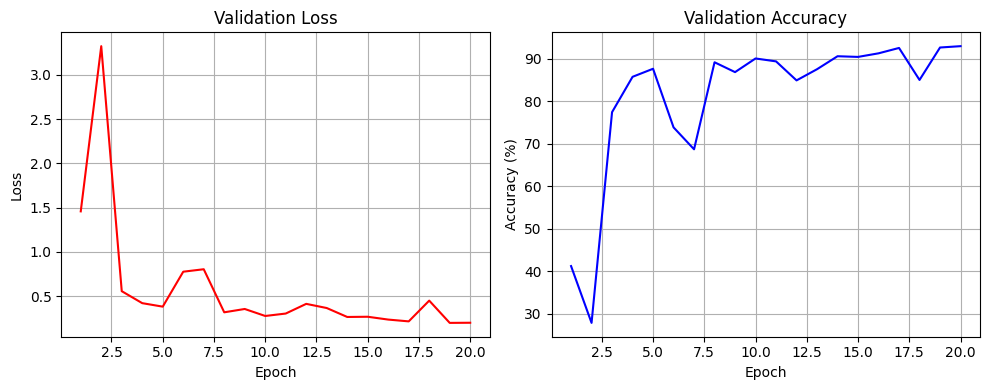

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.0015)

combined_metrics = train_validate(
    model=combined_model,
    train_dataloader=combined_train_dataloader,
    val_dataloader=combined_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_metrics)

## combined blurred dataset

In [22]:
blurred_trainset = BlurredDataset(trainset, blur=transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0)))
blurred_valset   = BlurredDataset(valset, blur=transforms.GaussianBlur(kernel_size=3, sigma=2.0))
blurred_testset  = BlurredDataset(testset, blur=transforms.GaussianBlur(kernel_size=3, sigma=2.0))

blurred_train_dataloader  = DataLoader(blurred_valset, batch_size=128, shuffle=True)
blurred_val_dataloader  = DataLoader(blurred_trainset, batch_size=128, shuffle=False)
blurred_test_dataloader  = DataLoader(blurred_testset, batch_size=128, shuffle=False)

In [23]:
combined_blurred_trainset = ConcatDataset([blurred_trainset, generated_trainset])
combined_blurred_valset   = ConcatDataset([blurred_valset, generated_valset])
combined_blurred_testset  = ConcatDataset([blurred_testset, generated_testset])

combined_blurred_train_dataloader = DataLoader(combined_blurred_trainset, batch_size=128, shuffle=True)
combined_blurred_val_dataloader   = DataLoader(combined_blurred_valset, batch_size=128, shuffle=False)
combined_blurred_test_dataloader  = DataLoader(combined_blurred_testset, batch_size=128, shuffle=False)


In [24]:
label_counts = {}
for _, targets in combined_blurred_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1560 images
Label 1: 2868 images
Label 2: 2727 images
Label 3: 1545 images
Label 4: 1684 images
Label 5: 3058 images


Epoch 1/20 | Train Loss: 1.3698 | Val Loss: 1.3697 | Val Acc: 44.87% | Val Precision: 0.5966 | Val Recall: 0.4207 | Val F1: 0.3902
Epoch 2/20 | Train Loss: 0.7760 | Val Loss: 0.6465 | Val Acc: 74.83% | Val Precision: 0.7489 | Val Recall: 0.7260 | Val F1: 0.7180
Epoch 3/20 | Train Loss: 0.5885 | Val Loss: 0.5895 | Val Acc: 76.20% | Val Precision: 0.7775 | Val Recall: 0.7365 | Val F1: 0.7138
Epoch 4/20 | Train Loss: 0.4934 | Val Loss: 0.5920 | Val Acc: 77.25% | Val Precision: 0.8125 | Val Recall: 0.7327 | Val F1: 0.7163
Epoch 5/20 | Train Loss: 0.4361 | Val Loss: 0.5060 | Val Acc: 79.41% | Val Precision: 0.8713 | Val Recall: 0.7419 | Val F1: 0.7704
Epoch 6/20 | Train Loss: 0.3848 | Val Loss: 0.3391 | Val Acc: 87.73% | Val Precision: 0.8730 | Val Recall: 0.8668 | Val F1: 0.8680
Epoch 7/20 | Train Loss: 0.3333 | Val Loss: 0.3607 | Val Acc: 86.62% | Val Precision: 0.8886 | Val Recall: 0.8383 | Val F1: 0.8554
Epoch 8/20 | Train Loss: 0.3173 | Val Loss: 0.3023 | Val Acc: 88.68% | Val Precisio

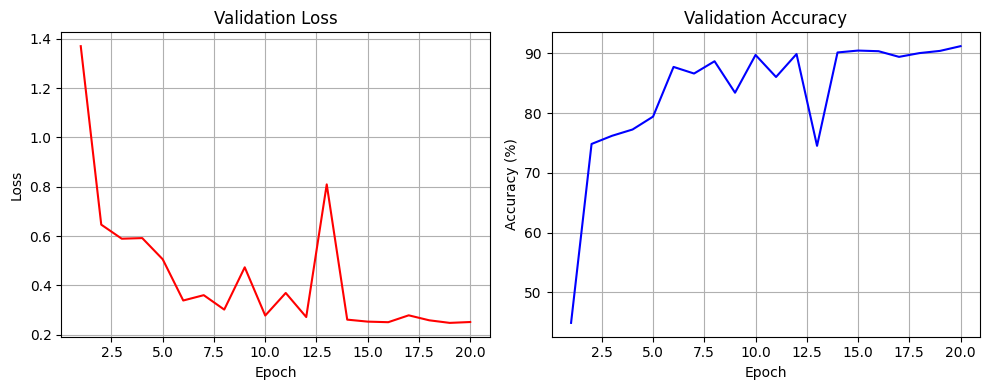

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_blurred_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_blurred_model.parameters(), lr=0.0015)

combined_blurred_metrics = train_validate(
    model=combined_blurred_model,
    train_dataloader=combined_blurred_train_dataloader,
    val_dataloader=combined_blurred_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_blurred_metrics)

## balanced dataset

In [32]:
def labels_array(ds):
    ys = np.empty(len(ds), dtype=np.int64)
    for i in range(len(ds)):
        _, y = ds[i]
        if isinstance(y, torch.Tensor):
            y = y.item()
        ys[i] = int(y)
    return ys

def balance_dataset(original_dataset, generated_dataset, target_per_class, classes=None, seed=42):
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)

    lbl_original = labels_array(original_dataset)
    lbl_generated  = labels_array(generated_dataset)

    if classes is None:
        classes = sorted(set(lbl_original.tolist()) | set(lbl_generated.tolist()))
    else:
        classes = sorted(int(c) for c in classes)

    original_by_class = {c: np.flatnonzero(lbl_original == c).tolist() for c in classes}
    generated_by_class  = {c: np.flatnonzero(lbl_generated  == c).tolist()  for c in classes}

    for c in classes:
        rng.shuffle(original_by_class[c])
        rng.shuffle(generated_by_class[c])

    take_original, take_generated = [], []

    for c in classes:
        original_i = original_by_class[c]
        generated_i  = generated_by_class[c]

        n_from_original = min(len(original_i), target_per_class)
        take_original.extend(original_i[:n_from_original])

        needed_generated = target_per_class - n_from_original
        if needed_generated > 0 and len(generated_i) > 0:
            n_from_generated = min(needed_generated, len(generated_i))
            take_generated.extend(generated_i[:n_from_generated])

    combined = ConcatDataset([
        Subset(original_dataset,  take_original),
        Subset(generated_dataset, take_generated),
    ])
    perm = np_rng.permutation(len(take_original) + len(take_generated)).tolist()
    return Subset(combined, perm)

In [33]:
target_per_class = 2500
n = len(used_classes)

concat_original_dataset = ConcatDataset([trainset, valset, testset]) 
concat_generated_dataset = ConcatDataset([generated_testset, generated_valset, generated_testset])

balanced_dataset = balance_dataset(
    original_dataset=concat_original_dataset,
    generated_dataset=concat_generated_dataset,
    target_per_class=target_per_class,
    #classes=range(n),
    seed=42
)

balanced_size = len(balanced_dataset)
balanced_train_size = int(0.7 * balanced_size)
balanced_val_size   = int(0.1 * balanced_size)
balanced_test_size  = balanced_size - balanced_train_size - balanced_val_size

balanced_trainset, balanced_valset, balanced_testset = torch.utils.data.random_split(
    balanced_dataset,
    [balanced_train_size, balanced_val_size, balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)
balanced_train_dataloader = DataLoader(balanced_trainset, batch_size=128, shuffle=True)
balanced_val_dataloader   = DataLoader(balanced_valset,   batch_size=128, shuffle=False)
balanced_test_dataloader  = DataLoader(balanced_testset,  batch_size=128, shuffle=False)

In [34]:
label_counts = {}
for _, targets in balanced_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1213 images
Label 1: 1718 images
Label 2: 1778 images
Label 3: 1199 images
Label 4: 1348 images
Label 5: 1739 images


Epoch 1/20 | Train Loss: 1.3777 | Val Loss: 1.0083 | Val Acc: 57.20% | Val Precision: 0.6203 | Val Recall: 0.5446 | Val F1: 0.5236
Epoch 2/20 | Train Loss: 0.8766 | Val Loss: 0.7990 | Val Acc: 70.66% | Val Precision: 0.7313 | Val Recall: 0.6931 | Val F1: 0.7014
Epoch 3/20 | Train Loss: 0.7174 | Val Loss: 0.6959 | Val Acc: 74.63% | Val Precision: 0.7669 | Val Recall: 0.7323 | Val F1: 0.7387
Epoch 4/20 | Train Loss: 0.6069 | Val Loss: 0.5119 | Val Acc: 81.17% | Val Precision: 0.7998 | Val Recall: 0.8012 | Val F1: 0.7965
Epoch 5/20 | Train Loss: 0.5277 | Val Loss: 0.5663 | Val Acc: 79.22% | Val Precision: 0.7951 | Val Recall: 0.7936 | Val F1: 0.7797
Epoch 6/20 | Train Loss: 0.4788 | Val Loss: 0.5428 | Val Acc: 81.56% | Val Precision: 0.8296 | Val Recall: 0.8126 | Val F1: 0.8047
Epoch 7/20 | Train Loss: 0.4284 | Val Loss: 0.4145 | Val Acc: 85.37% | Val Precision: 0.8535 | Val Recall: 0.8450 | Val F1: 0.8410
Epoch 8/20 | Train Loss: 0.4080 | Val Loss: 0.4141 | Val Acc: 85.84% | Val Precisio

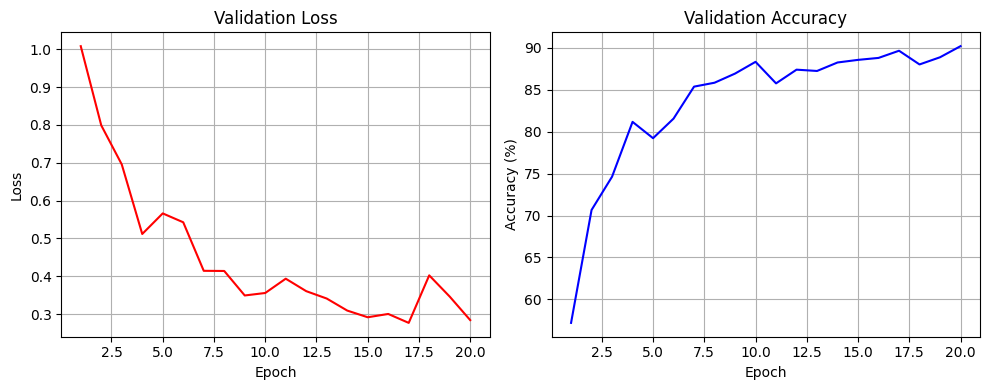

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
balanced_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(balanced_model.parameters(), lr=0.0015)

balanced_metrics = train_validate(
    model=balanced_model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(balanced_metrics)

## balanced blurred dataset

In [36]:
target_per_class = 2500
n = len(used_classes)

concat_blurred_dataset = ConcatDataset([blurred_trainset, blurred_valset, blurred_testset]) 
concat_generated_dataset = ConcatDataset([generated_testset, generated_valset, generated_testset])

blurred_balanced_dataset = balance_dataset(
    original_dataset=concat_blurred_dataset,
    generated_dataset=concat_generated_dataset,
    target_per_class=target_per_class,
    #classes=range(n),
    seed=42
)

blurred_balanced_size = len(blurred_balanced_dataset)
blurred_balanced_train_size = int(0.7 * blurred_balanced_size)
blurred_balanced_val_size   = int(0.1 * blurred_balanced_size)
blurred_balanced_test_size  = blurred_balanced_size - blurred_balanced_train_size - blurred_balanced_val_size

blurred_balanced_trainset, blurred_balanced_valset, blurred_balanced_testset = torch.utils.data.random_split(
    blurred_balanced_dataset,
    [blurred_balanced_train_size, blurred_balanced_val_size, blurred_balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

blurred_balanced_train_dataloader = DataLoader(blurred_balanced_trainset, batch_size=128, shuffle=True)
blurred_balanced_val_dataloader   = DataLoader(blurred_balanced_valset,   batch_size=128, shuffle=False)
blurred_balanced_test_dataloader  = DataLoader(blurred_balanced_testset,  batch_size=128, shuffle=False)

In [37]:
label_counts = {}
for _, targets in blurred_balanced_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1213 images
Label 1: 1718 images
Label 2: 1778 images
Label 3: 1199 images
Label 4: 1348 images
Label 5: 1739 images


Epoch 1/20 | Train Loss: 1.3905 | Val Loss: 1.0115 | Val Acc: 64.12% | Val Precision: 0.6765 | Val Recall: 0.6187 | Val F1: 0.5965
Epoch 2/20 | Train Loss: 0.9041 | Val Loss: 0.8891 | Val Acc: 64.51% | Val Precision: 0.6950 | Val Recall: 0.6220 | Val F1: 0.6139
Epoch 3/20 | Train Loss: 0.7494 | Val Loss: 0.6752 | Val Acc: 75.18% | Val Precision: 0.7584 | Val Recall: 0.7379 | Val F1: 0.7315
Epoch 4/20 | Train Loss: 0.6347 | Val Loss: 0.5856 | Val Acc: 77.51% | Val Precision: 0.7809 | Val Recall: 0.7603 | Val F1: 0.7499
Epoch 5/20 | Train Loss: 0.5803 | Val Loss: 0.5825 | Val Acc: 77.74% | Val Precision: 0.8251 | Val Recall: 0.7486 | Val F1: 0.7317
Epoch 6/20 | Train Loss: 0.5022 | Val Loss: 0.5071 | Val Acc: 82.18% | Val Precision: 0.8365 | Val Recall: 0.8095 | Val F1: 0.8158
Epoch 7/20 | Train Loss: 0.4655 | Val Loss: 0.4230 | Val Acc: 84.51% | Val Precision: 0.8386 | Val Recall: 0.8343 | Val F1: 0.8357
Epoch 8/20 | Train Loss: 0.4251 | Val Loss: 0.4371 | Val Acc: 82.65% | Val Precisio

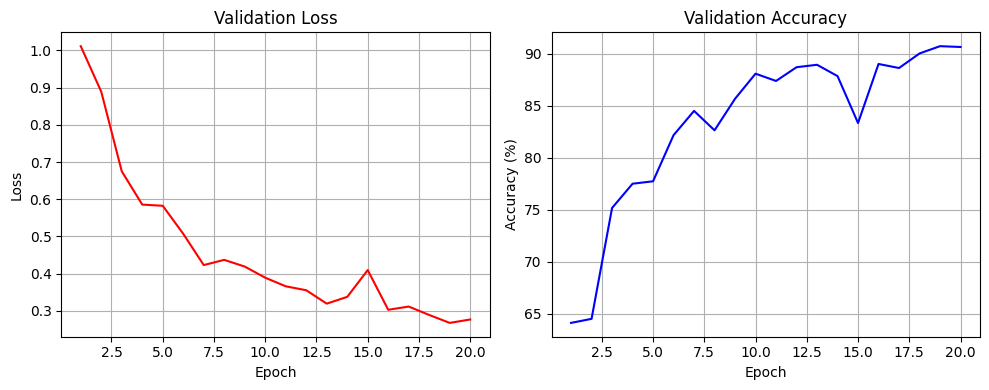

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blurred_balanced_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(blurred_balanced_model.parameters(), lr=0.0015)

blurred_balanced_metrics = train_validate(
    model=blurred_balanced_model,
    train_dataloader=blurred_balanced_train_dataloader,
    val_dataloader=blurred_balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(blurred_balanced_metrics)

In [39]:
def test_model(model, test_dataloader, device, classes=range(n)):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_predictions.append(preds)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm=confusion_matrix(all_labels, all_predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    

    print(f"Test Accuracy: {accuracy:.4f} | "
            f"Test Precision: {precision:.4f} | "
            f"Test Recall: {recall:.4f} | "
            f"Test F1: {f1:.4f}")

    disp.plot()
    plt.show()

Original model
Test Accuracy: 0.8989 | Test Precision: 0.9022 | Test Recall: 0.8757 | Test F1: 0.8856


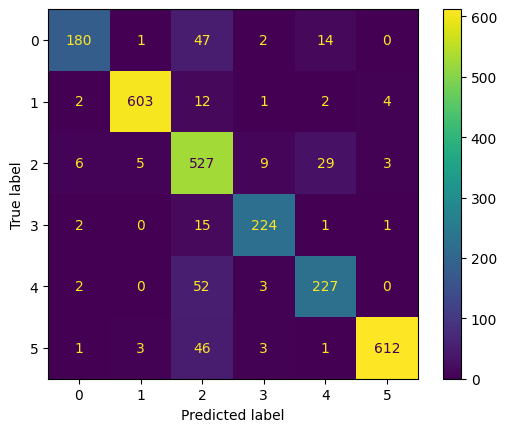

Generated model
Test Accuracy: 0.3227 | Test Precision: 0.4057 | Test Recall: 0.3840 | Test F1: 0.3002


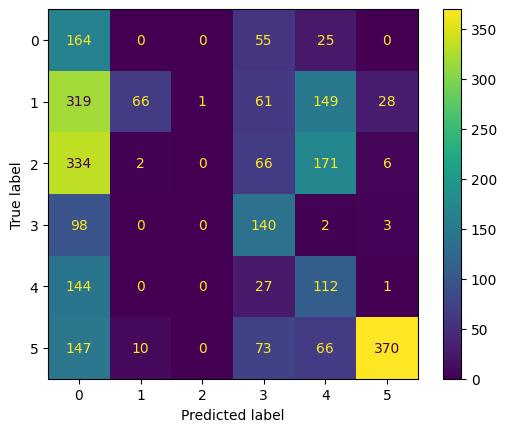

Combined model
Test Accuracy: 0.8913 | Test Precision: 0.8932 | Test Recall: 0.8605 | Test F1: 0.8738


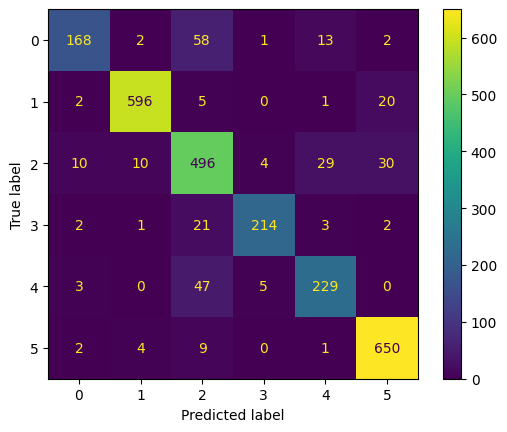

Combined blurred model
Test Accuracy: 0.8617 | Test Precision: 0.8273 | Test Recall: 0.8436 | Test F1: 0.8315


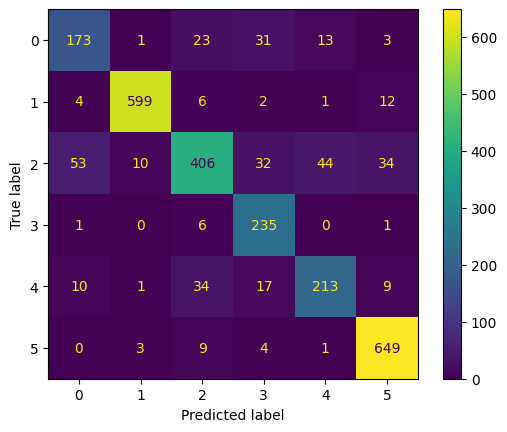

Balanced model
Test Accuracy: 0.9170 | Test Precision: 0.9133 | Test Recall: 0.8987 | Test F1: 0.9044


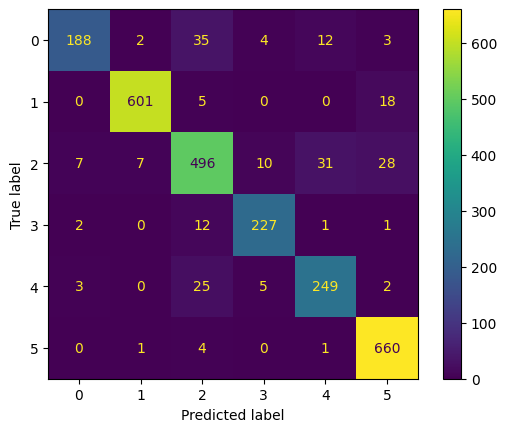

Blurred balanced model
Test Accuracy: 0.8424 | Test Precision: 0.8314 | Test Recall: 0.8449 | Test F1: 0.8167


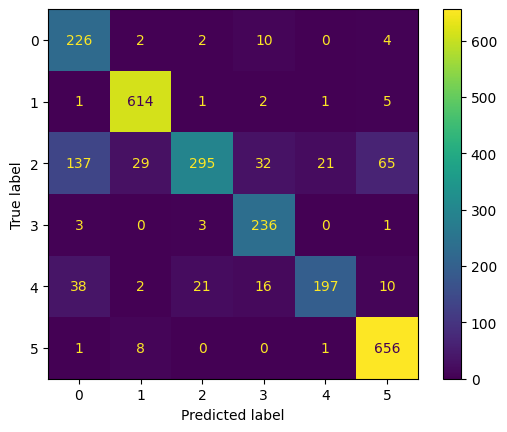

In [41]:
print("Original model")
test_model(model=original_model, test_dataloader=test_dataloader, device=device)

print("Generated model")
test_model(model=generated_model, test_dataloader=test_dataloader, device=device)

print("Combined model")
test_model(model=combined_model, test_dataloader=test_dataloader, device=device)

print("Combined blurred model")
test_model(model=combined_blurred_model, test_dataloader=test_dataloader, device=device)

print("Balanced model")
test_model(model=balanced_model, test_dataloader=test_dataloader, device=device)

print("Blurred balanced model")
test_model(model=blurred_balanced_model, test_dataloader=test_dataloader, device=device)

Original model
Test Accuracy: 0.7383 | Test Precision: 0.8605 | Test Recall: 0.6649 | Test F1: 0.6662


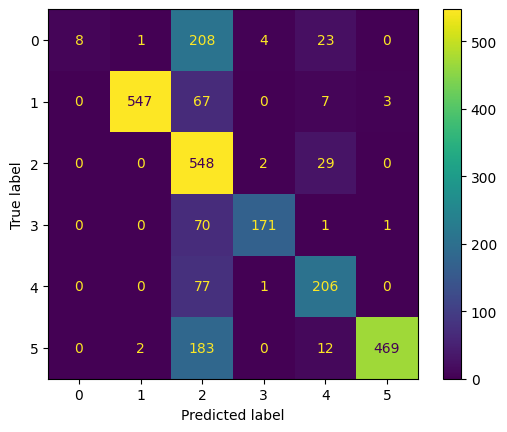

Generated model
Test Accuracy: 0.3367 | Test Precision: 0.3880 | Test Recall: 0.3860 | Test F1: 0.3195


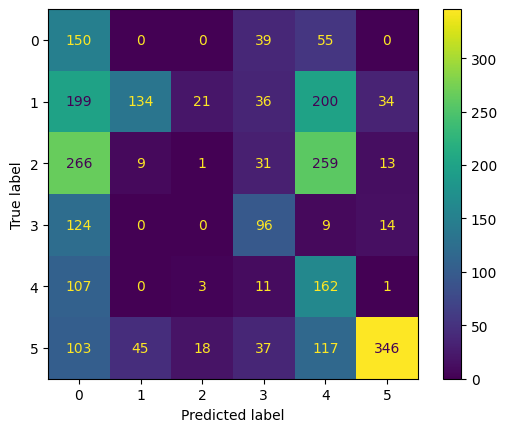

Combined model
Test Accuracy: 0.8496 | Test Precision: 0.8661 | Test Recall: 0.7859 | Test F1: 0.8060


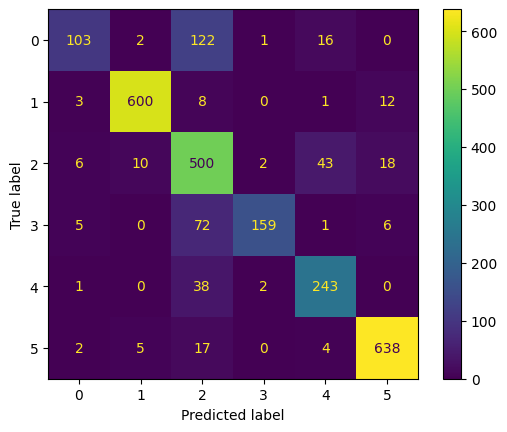

Combined blurred model
Test Accuracy: 0.8716 | Test Precision: 0.8798 | Test Recall: 0.8233 | Test F1: 0.8377


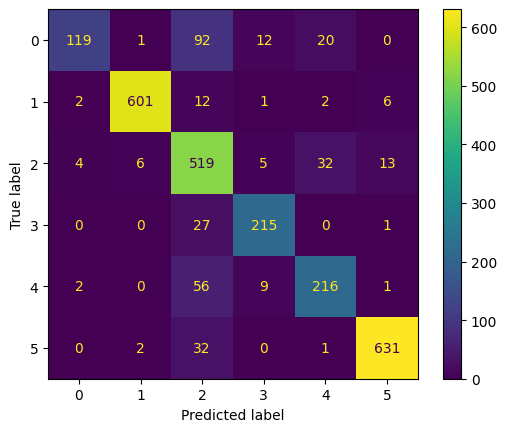

Balanced model
Test Accuracy: 0.8538 | Test Precision: 0.8699 | Test Recall: 0.8135 | Test F1: 0.8196


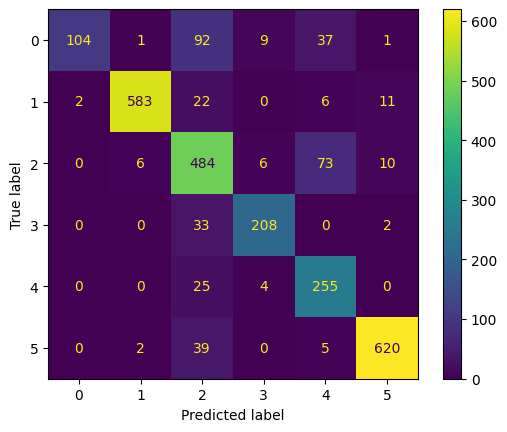

Blurred balanced model
Test Accuracy: 0.9080 | Test Precision: 0.8981 | Test Recall: 0.8942 | Test F1: 0.8944


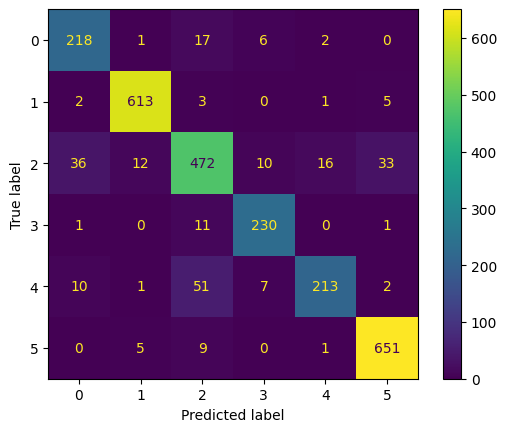

In [42]:
print("Original model")
test_model(model=original_model, test_dataloader=blurred_test_dataloader, device=device)

print("Generated model")
test_model(model=generated_model, test_dataloader=blurred_test_dataloader, device=device)

print("Combined model")
test_model(model=combined_model, test_dataloader=blurred_test_dataloader, device=device)

print("Combined blurred model")
test_model(model=combined_blurred_model, test_dataloader=blurred_test_dataloader, device=device)

print("Balanced model")
test_model(model=balanced_model, test_dataloader=blurred_test_dataloader, device=device)

print("Blurred balanced model")
test_model(model=blurred_balanced_model, test_dataloader=blurred_test_dataloader, device=device)